# R(2+1)D Model Fine-tuning on HMDB51  

In this notebook, we show how to finetune the pretrained R(2+1)D model. We use [HMDB51](http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/) human action dataset for this example.

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
sys.path.append("../../")
import time
import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.cuda as cuda
import torch.nn as nn
import torchvision

from utils_cv.action_recognition.dataset import show_batch, VideoDataset
from utils_cv.action_recognition.model import R2Plus1D 
from utils_cv.common.gpu import system_info

system_info()

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0] 

PyTorch 1.2.0 

Torch-vision 0.4.0a0 

Available devices:
0: Tesla V100-PCIE-16GB


### Prerequisites
* Download and extract HMDB51 videos under `./data/hmdb51/videos` directory. 

In [19]:
from utils_cv.common.data import data_path

In [20]:
DATA_ROOT = os.path.join(str(data_path()), "misc/hmdb51")
VIDEO_DIR = os.path.join(DATA_ROOT, "videos")
# This split is known as "split1"
TRAIN_SPLIT = os.path.join(DATA_ROOT, "hmdb51_vid_train_split_1.txt")
TEST_SPLIT = os.path.join(DATA_ROOT, "hmdb51_vid_val_split_1.txt")

## Model and Training Configurations

Using the paramters below, one can reproduce published results on the HMDB-51 dataset. Video-clip accuracy of close to 80%  can be obtained using as input to the DNN 32 consecutive frames (`MODEL_INPUT_SIZE`) and running 48 training epochs. Even using only 8 epochs the accuracy already reaches 75%. Inference and training speed can be reduced by a factor of 3-4 by setting `MODEL_INPUT_SIZE=8` and using higher batch size, however at a significant loss in accuracy.

In [21]:
# Number of consecutive frames used as input to the DNN. Recommended: 32 for high accuracy, 8 for inference speed.
MODEL_INPUT_SIZE = 8

# Batch size. Reduce if running out of memory.
BATCH_SIZE = 8        

# Number of training epochs
EPOCHS = 8

# Model configuration
r2plus1d_hmdb51_cfgs = dict(
    # HMDB51 dataset spec
    num_classes=51,
    video_dir=VIDEO_DIR,
    train_split=TRAIN_SPLIT,
    valid_split=TEST_SPLIT,
    # Pre-trained model spec ("Closer look" and "Large-scale" papers)
    base_model='ig65m',
    sample_length=MODEL_INPUT_SIZE,     
    sample_step=1,        # Frame sampling step
    im_scale=128,         # After scaling, the frames will be cropped to (112 x 112)
    mean=(0.43216, 0.394666, 0.37645),
    std=(0.22803, 0.22145, 0.216989),
    random_shift=True,
    temporal_jitter_step=2,    # Temporal jitter step in frames (only for training set)
    flip_ratio=0.5,
    random_crop=True,
    video_ext='avi',
)

# Training configuration
train_cfgs = dict(
    epochs=EPOCHS,                       # Number of training epochs
    lr=0.0001,                           # Learning rate
    lr_step_size = np.ceil(2/3*EPOCHS),  # Reduce learning rate by factor of 10 after this many epochs.
    batch_size=BATCH_SIZE,               # Model batch size. Reduce if model cannot fit into memory.
    
    # No need to change these parameters
    grad_steps=2,          # Accumulate the gradients over multiple forward passes
    mixed_prec=False,      # Use mixed precision to speed up training
)

## Load Model and Data

Load R(2+1)D 34-layer model pre-trained on IG65M. There are two versions of the model: 8-frame model and 32-frame model based on the input clip length.

In [22]:
learn = R2Plus1D(r2plus1d_hmdb51_cfgs)

Loading r2plus1d_34_8_ig65m model


Using cache found in /home/jiata/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


Model structure

In [23]:
learn.model

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=Tru

Three examples of training (transformed) clips. 

<Figure size 432x288 with 0 Axes>

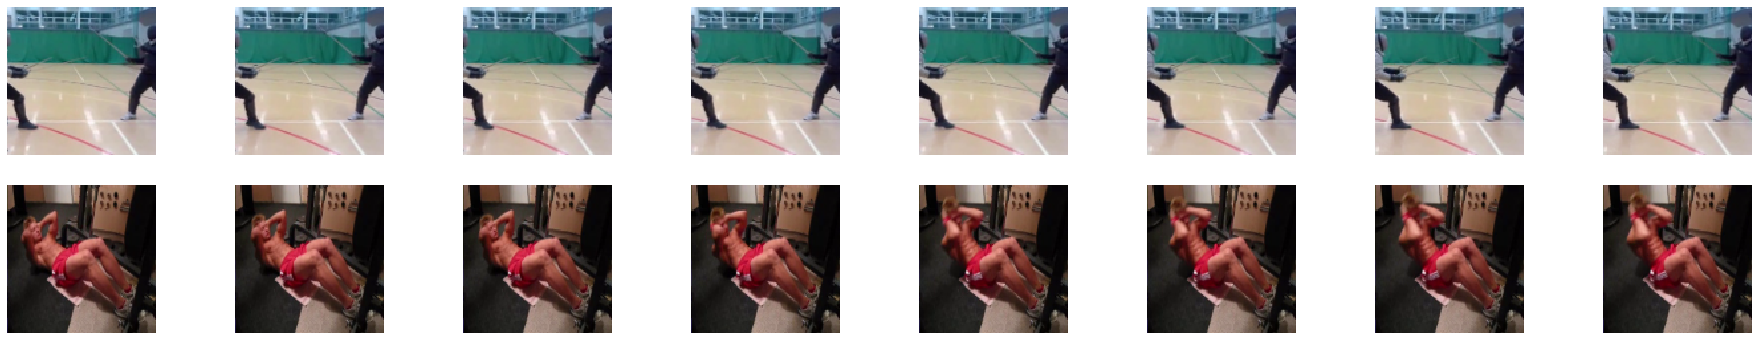

In [24]:
learn.show_batch(num_samples=2)

## Fine-tuning

In [12]:
learn.fit(train_cfgs)

Params to learn:
	full network
Epoch 1 ==========
lr=[0.0001]
train took 208.61 sec: loss = 3.6626, top1_acc = 17.1709, top5_acc = 37.5070
valid took 76.40 sec: loss = 3.0884, top1_acc = 26.4052, top5_acc = 59.8039
Epoch 2 ==========
lr=[0.0001]
train took 208.16 sec: loss = 2.9141, top1_acc = 42.8852, top5_acc = 72.9692
valid took 67.63 sec: loss = 2.3432, top1_acc = 42.8758, top5_acc = 69.8693
Epoch 3 ==========
lr=[0.0001]
train took 211.29 sec: loss = 2.3512, top1_acc = 53.8936, top5_acc = 82.6611
valid took 70.57 sec: loss = 2.0275, top1_acc = 47.5817, top5_acc = 74.0523
Epoch 4 ==========
lr=[0.0001]
train took 225.18 sec: loss = 1.9487, top1_acc = 58.5714, top5_acc = 86.9188
valid took 71.59 sec: loss = 1.6414, top1_acc = 58.1046, top5_acc = 85.9477
Epoch 5 ==========
lr=[0.0001]
train took 213.21 sec: loss = 1.6954, top1_acc = 64.0336, top5_acc = 89.2437
valid took 71.39 sec: loss = 1.5467, top1_acc = 56.6013, top5_acc = 86.3399
Epoch 6 ==========
lr=[0.0001]
train took 219.96 

Each accuracy is averaged batch-wise accuracy.

## Model Test

Reported accuracy from "Closer look" paper: 74.5% (clip accuracy of 66.1% on split1 based on VMZ repo)

1. sample 10 clips uniformly sampled from each test video: [10 x 3 x (8 or 32) x 112 x 112]
2. calculate clip-level accuracy: Use 10 batch and infer
3. calculate video-level accuracy by averaging them
4. average over the clips

In [25]:
# ### Load Saved Weights if needed
#learn.load(body_train_cfgs['model_name'] + "_032", body_train_cfgs['model_dir'])

In [26]:
if cuda.is_available():
    device = torch.device("cuda")
    num_gpus = cuda.device_count()
    # Look for the optimal set of algorithms to use in cudnn. Use this only with fixed-size inputs.
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
    num_gpus = 0

1530 samples of torch.Size([3, 8, 112, 112])


<Figure size 432x288 with 0 Axes>

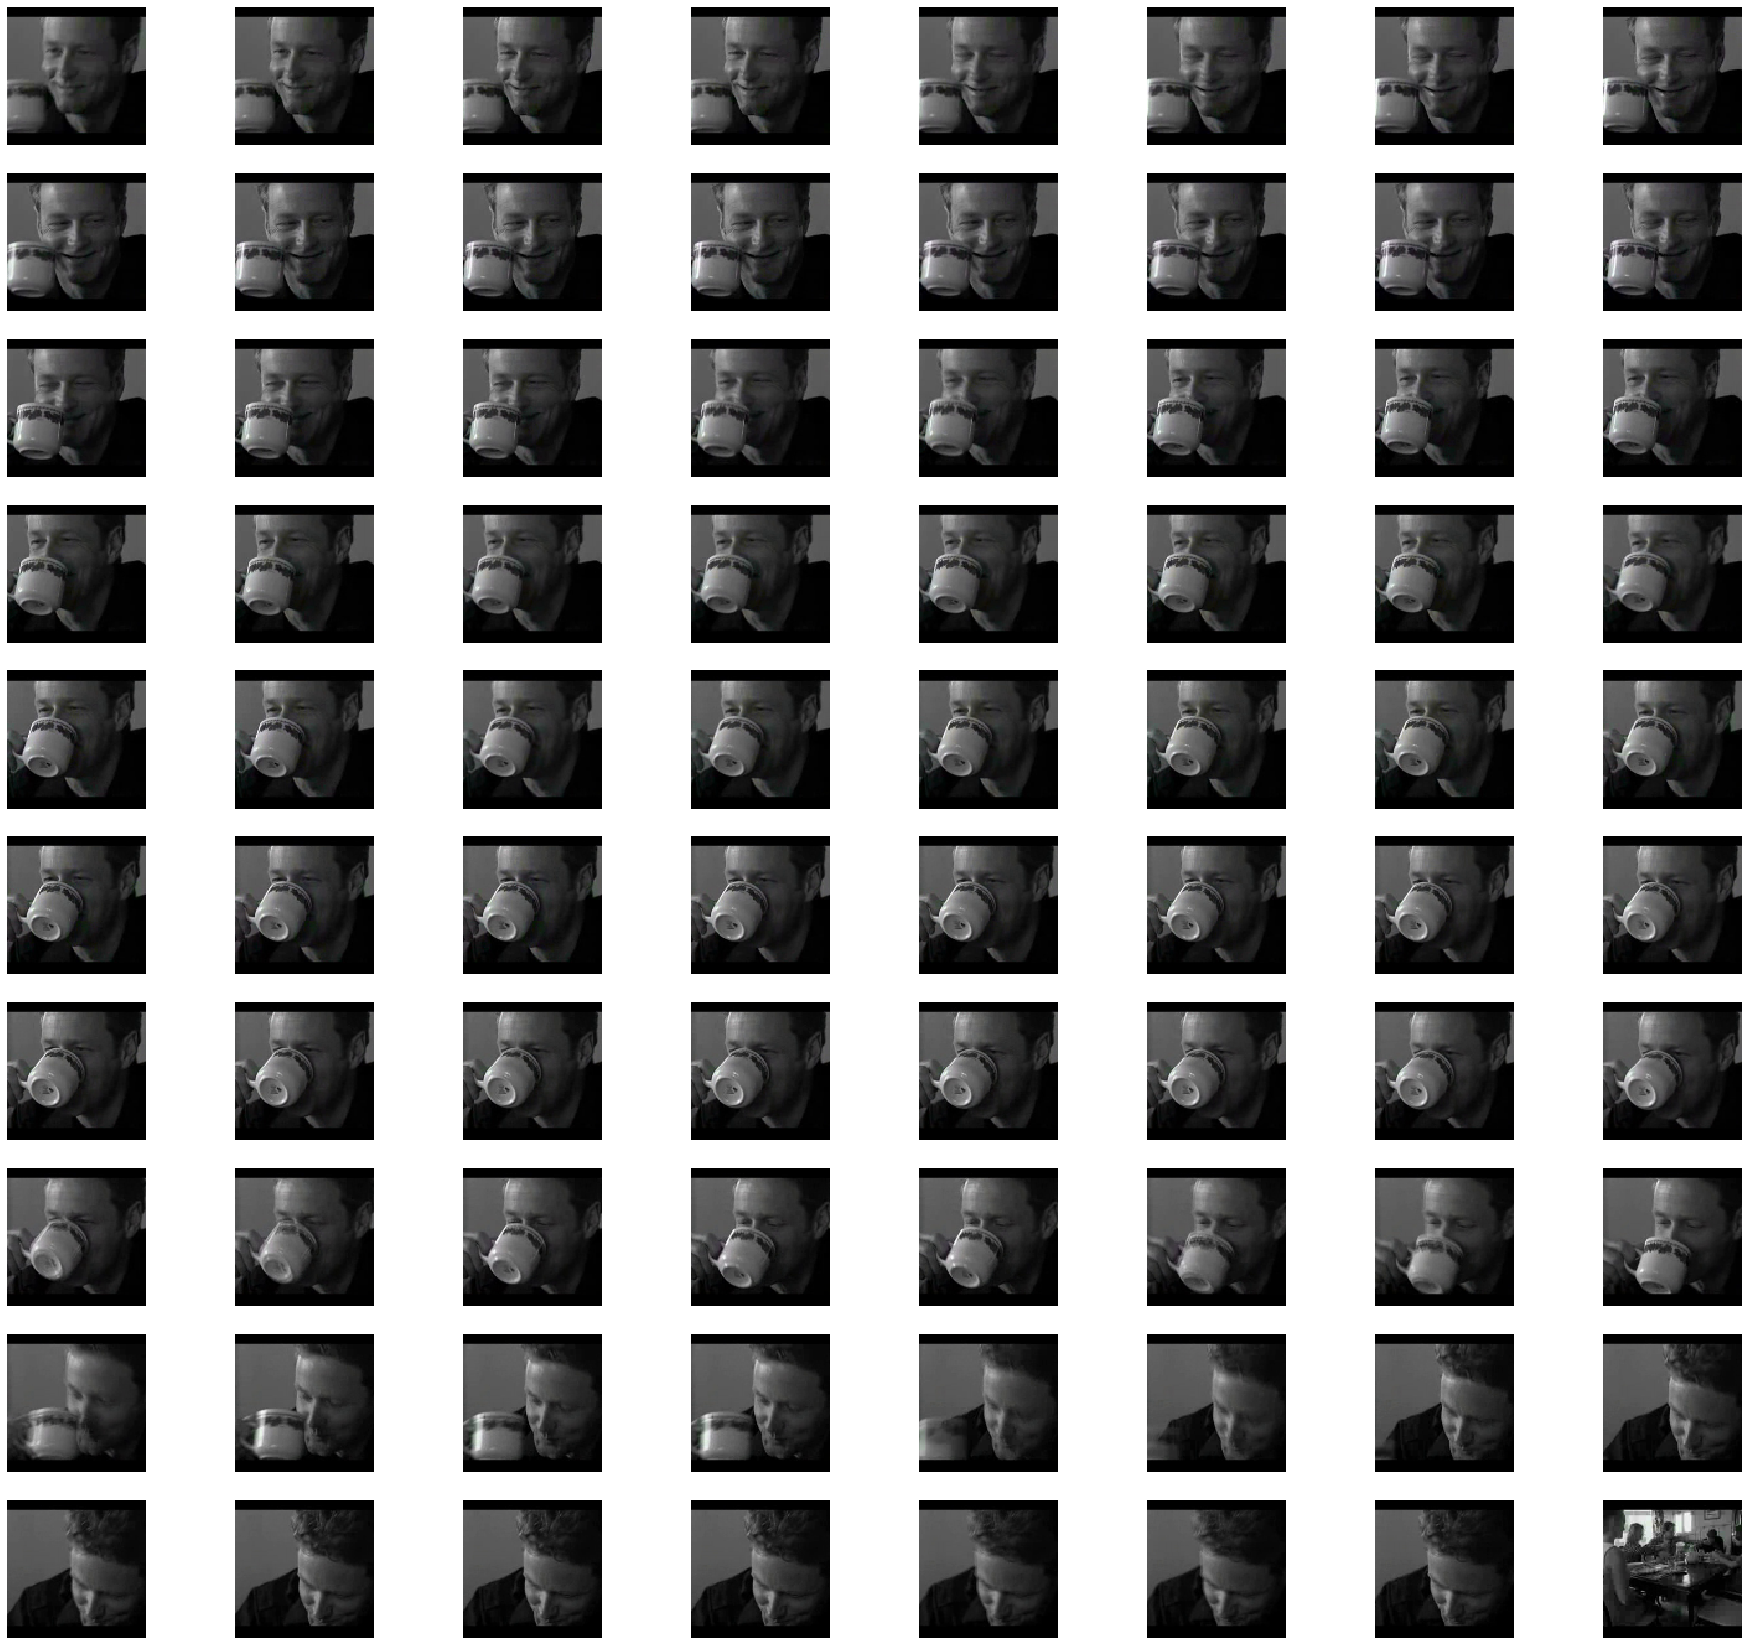

In [27]:
# Uniformly sample 10 clips per videos ("Closer look" papers)
num_segments = 10
test_ds = VideoDataset(
    split_file=r2plus1d_hmdb51_cfgs['valid_split'],
    video_dir=r2plus1d_hmdb51_cfgs['video_dir'],
    num_segments=num_segments,
    sample_length=r2plus1d_hmdb51_cfgs['sample_length'],
    sample_step=1,
    input_size=112,
    im_scale=r2plus1d_hmdb51_cfgs['im_scale'],
    resize_keep_ratio=True,
    mean=r2plus1d_hmdb51_cfgs['mean'],
    std=r2plus1d_hmdb51_cfgs['std'],
    random_shift=False,
    temporal_jitter=False,
    flip_ratio=0.0,
    random_crop=False,
    random_crop_scales=None,
    video_ext=r2plus1d_hmdb51_cfgs['video_ext'],
)

print("{} samples of {}".format(len(test_ds), test_ds[0][0][0].shape))

show_batch(
    test_ds[0][0],
    r2plus1d_hmdb51_cfgs['sample_length'],
    r2plus1d_hmdb51_cfgs['mean'],
    r2plus1d_hmdb51_cfgs['std']
)

In [28]:
# Initialize the model
model = learn.model
model.to(device)
if num_gpus > 1:
    model = nn.DataParallel(model)
model.eval()

# Loop over all examples in the test set and compute accuracies
infer_times = []
video_preds = []
video_trues = []
clip_preds = []
clip_trues = []
report_every = 100

with torch.no_grad():
    for i in range(1, len(test_ds)): #[::10]:  # Skip some examples to speed up accuracy computation
        if i % report_every == 0:
            print("Processsing {} of {} samples..".format(i, len(test_ds)))
        
        # Get model inputs
        inputs, label = test_ds[i]
        inputs = inputs.to(device, non_blocking=True)
        
        # Run inference
        start_time = time.time()
        outputs = model(inputs)
        outputs = outputs.cpu().numpy()
        infer_time = time.time() - start_time
        infer_times.append(infer_time)
        
        # Store results
        video_preds.append(outputs.sum(axis=0).argmax())
        video_trues.append(label)
        clip_preds.extend(outputs.argmax(axis=1))
        clip_trues.extend([label] * num_segments)
        
print("Avg. inference time per video (10 clips) =", np.array(infer_times).mean() * 1000, "ms")
print("Video prediction accuracy =", accuracy_score(video_trues, video_preds))
print("Clip prediction accuracy =", accuracy_score(clip_trues, clip_preds))

Processsing 100 of 1530 samples..
Processsing 200 of 1530 samples..
Processsing 300 of 1530 samples..
Processsing 400 of 1530 samples..
Processsing 500 of 1530 samples..
Processsing 600 of 1530 samples..
Processsing 700 of 1530 samples..
Processsing 800 of 1530 samples..
Processsing 900 of 1530 samples..
Processsing 1000 of 1530 samples..
Processsing 1100 of 1530 samples..
Processsing 1200 of 1530 samples..
Processsing 1300 of 1530 samples..
Processsing 1400 of 1530 samples..
Processsing 1500 of 1530 samples..
Avg. inference time per video (10 clips) = 92.80486805443674 ms
Video prediction accuracy = 0.006540222367560497
Clip prediction accuracy = 0.008763897972531066
